# Phân tích cảm xúc bình luận phim Imdb và phân loại đánh giá hình ảnh chó mèo
Trong assignment này, chúng ta sẽ xây dựng hai bộ phân loại học máy. Bộ phân loại đầu tiên được huấn luyện để nhận diện xem bình luận phim là tích cực hay tiêu cực, ở đây chúng ta sử dụng tập dữ liệu [Imdb movie reviews](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) chứa 5000 bài bình luận có một nửa là tích cực, một nửa là tiêu cực. Bộ phân loại thứ hai là phân loại hình ảnh có thể dự đoán đó hình ảnh về chó hay mèo. Chúng ta sử dụng tập dữ liệu [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data) từ cuộc thi Dogs vs. Cats trên Kaggle gồm 25000 hình ảnh về chó và mèo. 
<br>
Mục đích chính của notebook này là chỉ cho bạn các bước cơ bản khi huấn luyện một mô hình học máy như sau:
1. Nhận dữ liệu
2. Load và tiền xử lý dữ liệu
3. Chọn mô hình
4. Huấn luyện mô hình
5. Đánh giá mô hình
6. Cải thiện mô hình

## Phân tích cảm xúc bình luận phim
Chúng ta hãy xây dựng bộ phân loại đầu tiên.

### Import libs

In [8]:
import re
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Download dữ liệu
Download tập dữ liệu [Imdb movie reviews](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) trích và đặt folder **aclImdb** vào folder **data**.

### Load tập dữ liệu

In [13]:
def load_train_test_imdb_data(data_dir):
    """Loads the IMDB train/test datasets from a folder path.
    Input:
    data_dir: path to the "aclImdb" folder.
    
    Returns:
    train/test datasets as pandas dataframes.
    """

    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r", 
                encoding="utf-8") as f:
                    review = f.read()
                    data[split].append([review, score])
    
    # CODE CỦA BẠN Ở ĐÂY
    # Xáo trộn dữ liệu huấn luyện sử dụng "np.random.shuffle":
    np.random.seed(0)
    np.random.shuffle(data['train'])
    # Tạo khung dữ liệu huấn luyện "data["train"])" chỉ có 2 cột: "text" và "sentiment"      
    data["train"] = pd.DataFrame(data["train"], columns=['text', 'sentiment'])

    # Xáo trộn dữ liệu kiểm tra sử dụng "np.random.shuffle":
    np.random.seed(0)
    np.random.shuffle(data['test'])
    # Tạo khung dữ liệu kiểm tra "data["test"])" chỉ có 2 cột: "text" và "sentiment"      
    data["test"] = pd.DataFrame(data["test"], columns=['text', 'sentiment'])

    return data["train"], data["test"]

**load_train_test_imdb_data** giúp load các tập dữ liệu vào bên trong folder **acllmdb**.
<br>
Hoàn thành cell bên dưới để load các tập dữ liệu bên trong folder **acllmdb** bằng cách sử dụng **load_train_test_imdb_data** ở trên.
<br>
Sẽ mất vài phút để load các tập dữ liệu.
Sau khi load xong, bây giờ chúng ta có các dataframe (khung dữ liệu) **train_data** và **test_data**. 

In [14]:
# CODE CỦA BẠN Ở ĐÂY
# Load tập dữ liệu
train_data, test_data = load_train_test_imdb_data('./data/aclImdb')
# CODE CỦA BẠN Ở ĐÂY

In ra năm mục đầu tiên và các shape của tập dữ liệu **train_data** và **test_data**.

In [15]:
# CODE CỦA BẠN Ở ĐÂY
train_data.head()
# CODE CỦA BẠN Ở ĐÂY

,text,sentiment
0,This movie is the first of the six infamous Gu...,1
1,I am still trying to determine whether the pre...,0
2,If you're a a fan of either or both Chuck Norr...,1
3,"First off, I agree with quite a bit that escap...",0
4,I caught this at a test screening. All I can s...,0


In [16]:
test_data.head()

,text,sentiment
0,I watched this movie again yesterday with a 20...,1
1,Maybe this was *An Important Movie* and that's...,0
2,This is a perfect movie to watch with a loved ...,1
3,I am currently watching this movie and I have ...,0
4,Director Fabio Barreto got a strange Academy N...,0


### Tiền xử lý bình luận
Chúng ta có hàm **clean_text** giúp dọn các bình luận do đó việc huấn luyện mô hình sẽ dễ dàng hơn. Ở đây chúng ta dọn những thứ như HTML tag, loại bỏ dấu chấm, chuyển chữ viết hoa thành chữ thường. 

In [19]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # loại bỏ HTML tag
    text = re.sub(r'<.*?>', '', text)
    
    # CODE CỦA BẠN Ở ĐÂY
    # loại bỏ các ký tự [\], ['] và ["] bằng phương thức resub:
    text = re.sub(r'[\\]','', text)

    text = re.sub(r'[\']','', text)   

    text = re.sub(r'["]','', text)    
    # CODE CỦA BẠN Ở ĐÂY
    
    # chuyển đổi văn bản thành chữ thường
    text = text.strip().lower()
    
    # thay dấu chấm bằng dấu cách
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

# Ví dụ
clean_text("<html>This is not a sentence.<\html>").split()

['this', 'is', 'not', 'a', 'sentence']

### Biểu diễn bình luận dưới dạng vectơ
Để huấn luyện các bình luận với mô hình học máy, chúng ta cần chuyển chúng thành các vectơ. Có nhiều cách để chuyển một bình luận thành vectơ (văn bản nói chung), ở đây chúng ta sử dụng mô hình [túi từ (bag-of-words)](https://en.wikipedia.org/wiki/Bag-of-words_model) thường được dùng khi huấn luyện với các thuật toán học máy truyền thống. Chúng ta sẽ sử dụng sickit-learn [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) giúp tạo túi từ dễ dàng hơn. Hãy chạy cell bên dưới để xem ví dụ. 

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

training_texts = [
    "This is a good cat",
    "This is a bad day"
]

test_texts = [
    "This day is a good day"
]

# vectorizer này sẽ giúp bỏ qua các stop word (từ dừng)
vectorizer = CountVectorizer(
    stop_words="english",
    preprocessor=clean_text
)

# CODE CỦA BẠN Ở ĐÂY
# khớp vectorizer trong văn bản huấn luyện "training_texts"
vectorizer.fit(training_texts)
# CODE CỦA BẠN Ở ĐÂY

# lấy từ vựng của vectorizer
inv_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
vocabulary = [inv_vocab[i] for i in range(len(inv_vocab))]

# Ví dụ về vectơ hóa
pd.DataFrame(
    data=vectorizer.transform(test_texts).toarray(),
    index=["test sentence"],
    columns=vocabulary
)

,bad,cat,day,good
test sentence,0,0,2,1


### Tạo CountVectorizer
Vectorier được dùng để vectơ hóa các bình luận.

In [22]:
# Chuyển mỗi văn bản thành một vectơ đếm từ
vectorizer = CountVectorizer(stop_words="english",
                             preprocessor=clean_text)

### Biến đổi bình luận thành vectơ

Chúng ta sẽ sử dụng hàm **fit_transform** của **vectorizer** để chuyển **train_data["text"]** và **test_data["text"]** thành các vectơ.

In [23]:
# CODE CỦA BẠN Ở ĐÂY
# Chuyển bình luận thành vectơ
training_features = vectorizer.fit_transform(train_data["text"])  
test_features = vectorizer.transform(test_data["text"])
# CODE CỦA BẠN Ở ĐÂY

### Tạo và huấn luyện mô hình
Có rất nhiều thuật toán học máy mà chúng ta có thể sử dụng trong trường hợp này. Ở đây chúng ta sử dụng Hồi quy Logistic, nó giúp huấn luyện rất nhanh và thường được sử dụng cho bài toán phân loại văn bản với tập dữ liệu nhỏ. Bạn có thể tìm hiểu thêm thông tin chi tiết về thuật toán này và nhiều thuật toán khác trong khóa học sau của chuyên ngành học máy này. Chạy cell bên dưới để tạo và huấn luyện mô hình.

In [24]:
from sklearn.svm import LinearSVC
# CODE CỦA BẠN Ở ĐÂY
# Gán "LinearSVC()" cho biến mô hình:
model = LinearSVC()

# Khớp mô hình với dữ liệu huấn luyện "training_features" và nhãn huấn luyện "train_data["sentiment"]":
model.fit(training_features, train_data["sentiment"])
# CODE CỦA BẠN Ở ĐÂY

/home/longg/miniconda3/envs/mlp-301x/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC()

### Đánh giá mô hình
Chúng ta sẽ sử dụng **accuracy_score** để đánh giá mô hình trên **test_data**. Xem tra tài liệu [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ở đây. Hãy hoàn thành code bên dưới để tính độ chính xác của mô hình trên **test_data**.

In [25]:
from sklearn.metrics import accuracy_score

# CODE CỦA BẠN Ở ĐÂY
# Dự đoán tập dữ liệu kiểm tra:
y_test_pred = model.predict(test_features)
# Đánh giá
acc = accuracy_score(test_data['sentiment'], y_test_pred)
# CODE CỦA BẠN Ở ĐÂY

print("Accuracy on the IMDB dataset: {:.2f}%".format(acc*100))

Accuracy on the IMDB dataset: 83.68%


**Quizz:** Độ chính xác của mô hình trên test set là bao nhiêu?
<br>
**Đáp án:** 83.68%

### (Tùy chọn) Đánh giá mô hình sử dụng f1 score
Hoàn thành cell bên dưới để nhận điểm thưởng. Hãy sử dụng f1 score để đánh giá mô hình.

In [26]:
from sklearn.metrics import f1_score

# CODE CỦA BẠN Ở ĐÂY
# Đánh giá sử dụng f1
f1 = f1_score(test_data['sentiment'], y_test_pred)
# CODE CỦA BẠN Ở ĐÂY

print("F1 on the IMDB dataset: {:.2f}".format(f1))

F1 on the IMDB dataset: 0.84


### Cải thiện mô hình
Bây giờ, chúng ta hãy cố gắng cải thiện độ chính xác của mô hình trên test set. Có nhiều cách để cải thiện hiện mô hình học máy, ở đây chúng ta sẽ thử một phương thức khác để biểu diễn các bình luận thành các vectơ có [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) với [n-gram](https://en.wikipedia.org/wiki/N-gram). Hãy chạy cell sau để huấn luyện mô hình mới và xem độ chính xác. 

In [27]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer


# Chuyển mỗi văn bản thành một vectơ đếm từ
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=clean_text,
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(train_data["text"])    
test_features = vectorizer.transform(test_data["text"])

# CODE CỦA BẠN Ở ĐÂY
# Huấn luyện
# Gán "LinearSVC()" vào một biến mô hình:
model = LinearSVC()

# Khớp mô hình với dữ liệu huấn luyện "training_features" và nhãn huấn luyện "train_data["sentiment"]":
model.fit(training_features, train_data['sentiment'])

# Dự đoán dữ liệu kiểm tra "test_features":
y_test_pred = model.predict(test_features)
# CODE CỦA BẠN Ở ĐÂY

# Đánh giá
acc = accuracy_score(test_data["sentiment"], y_test_pred)

print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))

Accuracy on the IMDB dataset: 88.66


**Quizz:** Độ chính xác của mô hình trên test set là bao nhiêu?
<br>
**Đáp án:** 88.66

### (Tùy chọn) Đánh giá mô hình đã carit hiện sử dụng f1 score
Hoàn thành cell bên dưới để nhận điểm thưởng. Sử dụng f1 score để đánh giá mô hình.

In [28]:
from sklearn.metrics import f1_score

# CODE CỦA BẠN Ở ĐÂY
# Đánh giá sử dụng f1
f1 = f1_score(test_data["sentiment"], y_test_pred)
# CODE CỦA BẠN Ở ĐÂY

print("F1 on the IMDB dataset: {:.2f}".format(f1))

F1 on the IMDB dataset: 0.89


## Phân loại hình ảnh chó mèo
Hãy xây dựng bộ phân loại hình ảnh chó-mèo thứ hai. Ở đây chúng ta sẽ sử dụng thuật toán Neural Network (mạng nơ-ron) cho bài toán phân loại ảnh này. Có nhiều kiểu kiến trúc mạng nơ-ron cho các bài toán khác nhau. Đơn giản nhất là **Mạng nơ-ron truyền thẳng (FNN)**. Với bài toán phân loại hình ảnh thì phù hợp dùng **Mạng nơ-ron tích chập (CNN)**. Tuy nhiên do khóa học này được thiết kế để giới thiệu các thuật toán Học máy căn bản mà **CNN** là một loại thuật toán nâng cao và framework mà chúng ta sử dụng trong suốt chứng chỉ là **scikit-learn** lại không hỗ trợ **CNN** nên ở đây chúng ta chỉ dùng **FNN** cho bài toán này để minh họa bài toán phân loại hình ảnh. 

### Import lib

In [29]:
import cv2

### Download tập dữ liệu
Chúng ta sẽ sử dụng tập dữ liệu [Dog vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) từ Kaggle.
<br>
Download tập dữ liệu từ link trên (trước tiên bạn cần tạo tài khoản Kaggle để download dữ liệu).
<br>
Sau khi download bạn sẽ nhận được một file zip là **dogs-vs-cats.zip**, hãy giải nén nó.
<br>
Sau khi giải nén sẽ được 3 file. Bạn chỉ cần file **train.zip** cho assignment này.
<br>
Giải nén tất cả hình ảnh trong file **train.zip** vào folder **dog_cat_train**.
<br>
Sao chép **dog_cat_train** vào folder **data** cho assignment này.

### Load dữ liệu

In [37]:
def get_cat_dog_data(folder, image_size):
    """
    Get the cat dog data
    Inputs: folder: The folder path
            image_size: Resize all the image sizes to image_size
    
    Output: images, labels numpy array
    """
    images, labels = [], []
    
    for file in os.listdir(folder):
        # CODE CỦA BẠN Ở ĐÂY
        # Load một hình ảnh vào image_data với đường dẫn hình ảnh là "os.path.join(folder, file)":
        image_data = cv2.imread(os.path.join(folder, file))

        # Thay đổi kích thước hình ảnh thành "(image_size, image_size)"":
        image_data = cv2.resize(image_data, (image_size, image_size))
        
        # Nối image_data vào list images:
        images.append(image_data)
        # Nối nhãn dữ liệu "dog" hoặc "cat" vào list labels dựa theo tên "file":
        # Nếu hình ảnh về chú chó, nhãn sẽ là is 1, nếu không sẽ là 0.
        object_name = str(file.split('.')[0])
        if object_name == 'dog':
            labels.append(1)
        else:
            labels.append(0)
            
        # CODE CỦA BẠN Ở ĐÂY
    return np.array(images), np.array(labels) 

Sử dụng hàm **get_cat_dog_data** để load dữ liệu bên trong folder **dog_cat_train**.
<br>
Sử dụng **image_size = 28** khi load dữ liệu. Ở đây chúng ta chia tỷ lệ tất cả các hình ảnh thành size 28x28.
<br>
Có thể tốn vài phút để tải hình ảnh.

In [38]:
# CODE CỦA BẠN Ở ĐÂY
images, labels = get_cat_dog_data('./data/dog_cat_train/train/', 28)
# CODE CỦA BẠN Ở ĐÂY

### In ra shape của biến **images** và **labels**

In [39]:
# CODE CỦA BẠN Ở ĐÂY
print("image shape" ,images.shape,"\nlabel shape" , labels.shape)
# CODE CỦA BẠN Ở ĐÂY

image shape (25000, 28, 28, 3) 
label shape (25000,)


Hãy hiển thị một số hình ảnh.

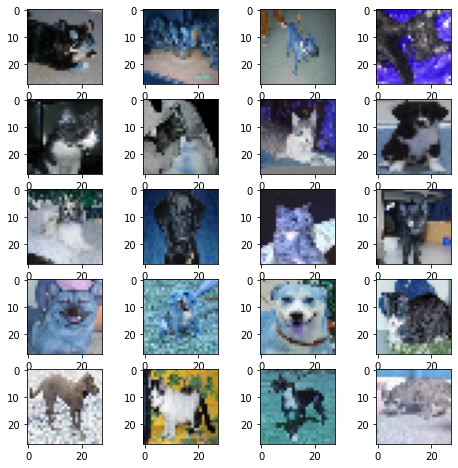

In [40]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i+12490])
plt.show()

### Tiền xử lý hình ảnh
Mỗi hình ảnh có shape 28x28x3 là một mảng ba chiều; để đưa hình ảnh vào thuật toán **FNN**, chúng ta cần chuyển đổi chúng thành mảng một chiều để có shape 2352. Chúng ta cũng chia tỷ lệ giá trị điểm ảnh theo phạm vi [0, 1].
<br>
Hoàn thành cell bên dưới. Reshape biến **images** thành shape (số lượng hình ảnh, 28*28*3). Chia tỷ lệ tất cả các giá trị thành phạm vi [0, 1] bằng cách chia cho 255.

In [41]:
# CODE CỦA BẠN Ở ĐÂY
# Reshape images, làm phẳng tất cả hình ảnh
# use the reshape function
images = images.reshape(-1, 28*28*3)
print(images.shape)

# Chia tỷ lệ mọi giá trị điểm ảnh giữa 0 và 1
images = images / 255.0
# CODE CỦA BẠN Ở ĐÂY

(25000, 2352)


### Chia tách tập dữ liệu
Hãy chia tập dữ liệu thành train/test với tỷ lệ 9:1. Chạy cell dưới đây để chia tập dữ liệu.

In [42]:
from sklearn.model_selection import train_test_split

# CODE CỦA BẠN Ở ĐÂY
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.9, random_state=42)
# CODE CỦA BẠN Ở ĐÂY

In ra shape của các biến **X_train, X_test, y_train, y_test**.
<br>
In ra số lượng chó, mèo cho tập dữ liệu huấn luyện và kiểm tra cho tập dữ liệu train và test sử dụng các biến **y_train** và **y_test**.

In [43]:
# CODE CỦA BẠN Ở ĐÂY
print('number of y_train', len(y_train), '\nnumber of y_test', len(y_test))
# CODE CỦA BẠN Ở ĐÂY

number of y_train 22500 
number of y_test 2500


### Tạo và huấn luyện mô hình
Hãy tạo và huấn luyện mô hình sử dụng **scikit-learn**. Bạn không cần lo lắng quá nhiều về chi tiết của mô hình lúc này, chúng ta sẽ nghiên cứu nó kỹ hơn trong khóa sau. Hãy chạy cell dưới đây để tạo và huấn luyện mô hình **MLPClassifier()** với các tham số: 

  * solver='adam'
  * alpha=1e-5
  * activation='relu'
  * hidden_layer_sizes=(64, 64)
  * random_state=1

Để biết thêm chi tiết về các tham số của MLPClassifier, hãy xem [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [44]:
from sklearn.neural_network import MLPClassifier

# tạo mô hình mạng nơ-ron truyền thẳng create the 
nn_model = MLPClassifier(solver='adam', alpha=1e-5, activation='relu', hidden_layer_sizes=(64, 64), random_state=1)

# huấn luyện mô hình
nn_model.fit(X_train, y_train)

/home/longg/miniconda3/envs/mlp-301x/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(64, 64), random_state=1)

### Đánh giá mô hình
Chúng ta sẽ sử dụng hàm **score** của lớp [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) để đánh giá độ chính xác của **X_train** và **X_test**.

In [45]:
# CODE CỦA BẠN Ở ĐÂY
# đánh giá mô hình
train_accuracy = nn_model.score(X_train, y_train)

test_accuracy = nn_model.score(X_test, y_test)
# CODE CỦA BẠN Ở ĐÂY

print ("train_accuracy: {:.2f}".format(train_accuracy))
print ("test_accuracy: {:.2f}".format(test_accuracy))

train_accuracy: 0.94
test_accuracy: 0.62


**Quizz:** Độ chính xác của mô hình trên train set là?
<br>
**Đáp án:** 0.94
<br>
**Quizz:** Độ chính xác của mô hình trên test set là?
<br>
**Đáp án:** 0.62

### (Tùy chọn) Đánh giá mô hình sử dụng f1 score
Hoàn thành cell bên dưới để nhận điểm thưởng.

In [46]:
from sklearn.metrics import f1_score

# CODE CỦA BẠN Ở ĐÂY
y_test_pred = nn_model.predict(X_test)

f1 = f1_score(y_test, y_test_pred)
# CODE CỦA BẠN Ở ĐÂY

print ("Test f1: {:.2f}".format(f1))

Test f1: 0.62
